In [8]:
import os
import sys
import subprocess

# Run pip install quietly
subprocess.run([sys.executable, "-m", "pip", "install", "nilearn", "statsmodels"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

CompletedProcess(args=['C:\\Users\\ferraras\\AppData\\Local\\miniforge3\\envs\\gradient\\python.exe', '-m', 'pip', 'install', 'nilearn', 'statsmodels'], returncode=0)

In [9]:
import os

# Set your working directory to your notebook folder
os.chdir(r"C:\Users\ferraras\OneDrive - Université de Genève\Documents\PhD_UNIGE\Project_FC_motivation\B_SNIP1")

# Confirm current directory
print("Current directory:", os.getcwd())

Current directory: C:\Users\ferraras\OneDrive - Université de Genève\Documents\PhD_UNIGE\Project_FC_motivation\B_SNIP1


# **Import FC matrices**

In [11]:
import numpy as np
import glob
from scipy.io import loadmat

# Get sorted list of mat files
files = np.sort(glob.glob("./Glasser_FC_BSNIP/*.mat"))
print(f"Found {len(files)} files.")

# Dictionary to hold FC matrices
fc = {}

for file_path in files:
    # Load mat file
    data = loadmat(file_path)
    
    # Extract matrix (assuming the variable name inside is 'subj_final_corr_mat')
    # Adjust if variable name is different in your files
    mat = data['FC_all'] 
    
    # Optional: if your matrices are 414x414 and you want to use full matrix,
    # no slicing needed here. Otherwise, you can slice if needed.
    # Example: mat = mat[:400, :400]
    
    # Extract subject ID from filename, e.g. 'sub01' from 'sub01_Glasser_FC.mat'
    import re
    match = re.search(r"(sub\d+)", file_path)
    if match:
        subj_id = match.group(1)
    else:
        subj_id = file_path  # fallback
    
    fc[subj_id] = mat

print("Loaded FC matrices")

Found 317 files.
Loaded FC matrices


# **Import demographic data**

In [13]:
import pandas as pd
import numpy as np

# Load your single CSV that includes diagnosis codes (adjust path and filename)
demo = pd.read_csv('bsnip1_gradients.csv')  # or .xlsx with pd.read_excel if needed

# Create DataFrame of FC subject IDs from your dictionary keys
id_df = pd.DataFrame({'participant_id': list(fc.keys())})

# Merge to keep only subjects with FC data
demo = pd.merge(id_df, demo, on='participant_id', how='inner')

# Use 'group_code' as diagnosis numeric code directly
demo['diagnosis'] = demo['group_code']

# If you want a simplified diagnosis grouping (e.g., merge bipolar(3) into schizophrenia(2))
demo['diagnosis2'] = demo['diagnosis'].copy()
demo.loc[demo['diagnosis2'] == 3, 'diagnosis2'] = 2

# Map gender 'M'/'F' to numbers to avoid warnings
demo['gender'] = demo['sex'].map({'M': 1, 'F': 2}).astype(int)

# Inspect
print(demo[['participant_id', 'diagnosis', 'diagnosis2', 'gender', 'interview_age']].head())

  participant_id  diagnosis  diagnosis2  gender  interview_age
0          sub01          1           1       2           45.6
1          sub02          7           7       2           72.0
2          sub03          6           6       2           28.8
3          sub04          4           4       2           60.0
4          sub05          1           1       1           31.2


## **Divide FC per group** ##

In [15]:
fc_SCHZ = np.array([fc.get(i) for i in demo['participant_id'][demo['group_code'] == 1]])   # Proband with Schizophrenia
fc_SCHZaff = np.array([fc.get(i) for i in demo['participant_id'][demo['group_code'] == 2]])  # Proband with Schizoaffective Disorder
fc_BP = np.array([fc.get(i) for i in demo['participant_id'][demo['group_code'] == 3]])      # Proband with Psychotic Bipolar Disorder
fc_REL_SCHZ = np.array([fc.get(i) for i in demo['participant_id'][demo['group_code'] == 4]])     # Relative of Proband with Schizophrenia
fc_REL_SCHZaff = np.array([fc.get(i) for i in demo['participant_id'][demo['group_code'] == 5]])  # Relative of Proband with Schizoaffective Disorder
fc_REL_BP = np.array([fc.get(i) for i in demo['participant_id'][demo['group_code'] == 6]])       # Relative of Proband with Psychotic Bipolar Disorder
fc_CTRL = np.array([fc.get(i) for i in demo['participant_id'][demo['group_code'] == 7]])         # Healthy Control

## **Import atlas** 

In [56]:
from matplotlib.colors import ListedColormap

# === Step 1: Read parcel names and colors ===
lut = pd.read_csv('Glasser360_Tian_Subcortex_S4_3T_order_info.txt', header=None)

# Extract parcel names (every odd row starting at 0)
lut_names = lut.iloc[0::2, 0].values

# Extract colors (every even row starting at 1), split and convert to int
lut_color = np.array([list(map(int, row.split())) for row in lut.iloc[1::2, 0].values])

# Colors format: ID, R, G, B, A — take RGB columns only (1:4)
rgb_colors = lut_color[:, 1:4]

# Create a ListedColormap normalized to [0,1]
network_cmap = ListedColormap(rgb_colors / 255)

# === Step 2: Read network labels for each parcel ===
network = np.loadtxt('Glasser_Tian_network_labels.txt', dtype=int)

# === Step 3: Define network names (adjust as needed) ===
net_name = ['_','VIS', 'SMN', 'DAN', 'VAN', 'LIM', 'FPN', 'DMN', 'SUB']

# **Plot functional connectivity matrices**

In [19]:
# Take only the first 360 x 360 from each subject before averaging
avg_fc_SCHZ = np.mean(fc_SCHZ[:, :360, :360], axis=0)
avg_fc_SCHZaff = np.mean(fc_SCHZaff[:, :360, :360], axis=0)
avg_fc_BP = np.mean(fc_BP[:, :360, :360], axis=0)
avg_fc_REL_SCHZ = np.mean(fc_REL_SCHZ[:, :360, :360], axis=0)
avg_fc_REL_SCHZaff = np.mean(fc_REL_SCHZaff[:, :360, :360], axis=0)
avg_fc_REL_BP = np.mean(fc_REL_BP[:, :360, :360], axis=0)
avg_fc_CTRL = np.mean(fc_CTRL[:, :360, :360], axis=0)

group_dict = {
    'SCHZ': fc_SCHZ,
    'SCHZaff': fc_SCHZaff,
    'BP': fc_BP,
    'REL_SCHZ': fc_REL_SCHZ,
    'REL_SCHZaff': fc_REL_SCHZaff,
    'REL_BP': fc_REL_BP,
    'CTRL': fc_CTRL,
}

avg_fc_dict = {group: np.mean(data, axis=0) for group, data in group_dict.items()}

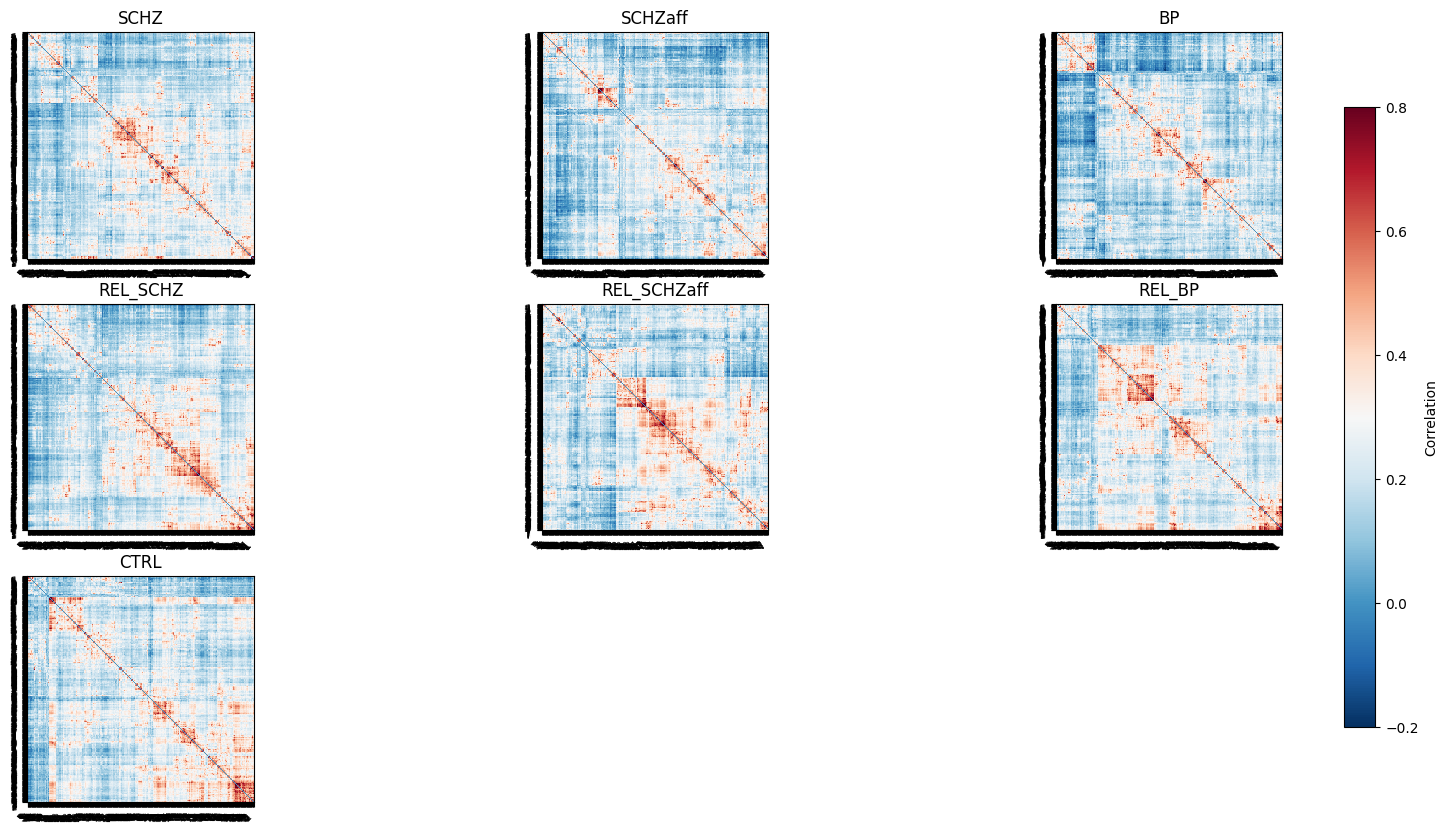

In [20]:
import matplotlib.pyplot as plt
from nilearn import plotting

fig, axes = plt.subplots(3, 3, figsize=(20, 10))  # 7 groups, so 8 subplots but last can be empty
axes = axes.flatten()
groups = list(avg_fc_dict.keys())

for i, group in enumerate(groups):
    display = plotting.plot_matrix(
        avg_fc_dict[group], axes=axes[i],
        labels=network, vmax=0.8, vmin=-0.2, reorder=True, colorbar=False
    )
    axes[i].set_title(group)

# Remove the last empty subplot if you want
if len(groups) < len(axes):
    for j in range(len(groups), len(axes)):
        fig.delaxes(axes[j])

# Add a single colorbar for the whole figure
# `display.img` is the image from the last call to plot_matrix, but its data is a matplotlib image
# so use the last display for the colorbar:
cbar = fig.colorbar(display, ax=axes.tolist(), orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Correlation')

plt.show()

# **Run gradient analysis**

In [22]:
from brainspace.gradient import GradientMaps
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels

# Dictionary to hold GradientMaps per group
gradients_dict = {}

# Loop through each group's average FC matrix
for group_name, avg_fc in avg_fc_dict.items():
    # Fit group-level gradients using Diffusion Maps (dm) as reference
    gm = GradientMaps(approach='dm', kernel='normalized_angle', n_components=3, random_state=0)
    gm.fit(avg_fc[:360, :360])  # Use first 360 parcels
    
    gradients_dict[group_name] = gm

# Load surface and labeling
surf_lh, surf_rh = load_conte69()
labeling = np.loadtxt('glasser_360_conte69.csv', dtype=int)
mask = labeling != 0

# Prepare gradients for plotting (map to surface)
gradients_mapped = {}

for group_name, gm in gradients_dict.items():
    grad_group = [
        map_to_labels(gm.gradients_[:, i], labeling, mask=mask, fill=np.nan)
        for i in range(3)
    ]
    gradients_mapped[group_name] = grad_group

# Compute global color range across all gradients and all groups
all_vals = np.concatenate([
    np.concatenate(grad_group) for grad_group in gradients_mapped.values()
])
vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)
color_range = (vmin, vmax)

## **Plot gradients**

Saving plot for SCHZ


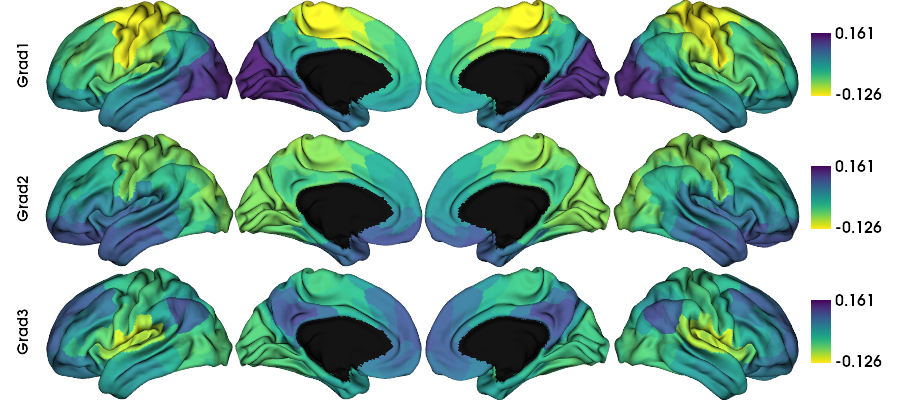

Saving plot for SCHZaff


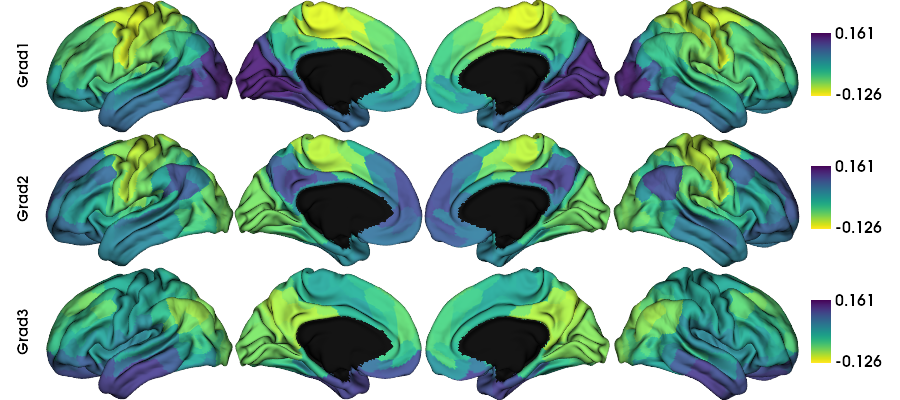

Saving plot for BP


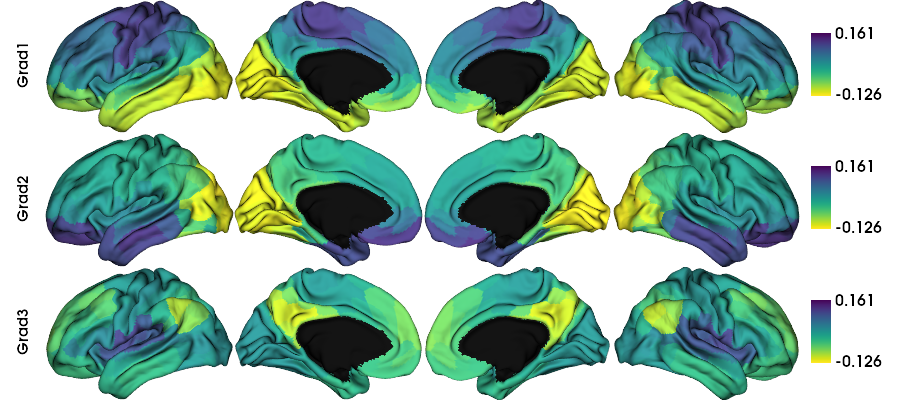

Saving plot for REL_SCHZ


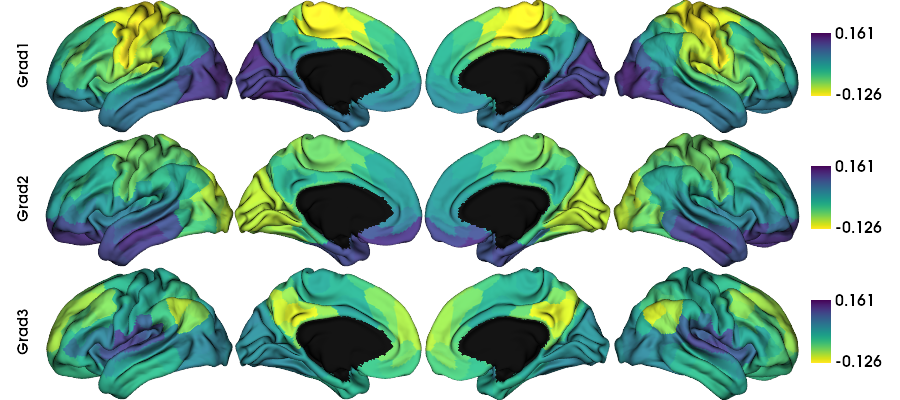

Saving plot for REL_SCHZaff


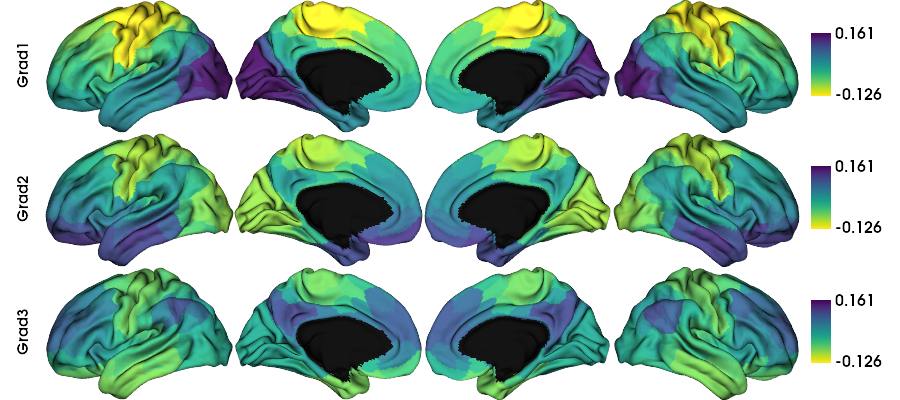

Saving plot for REL_BP


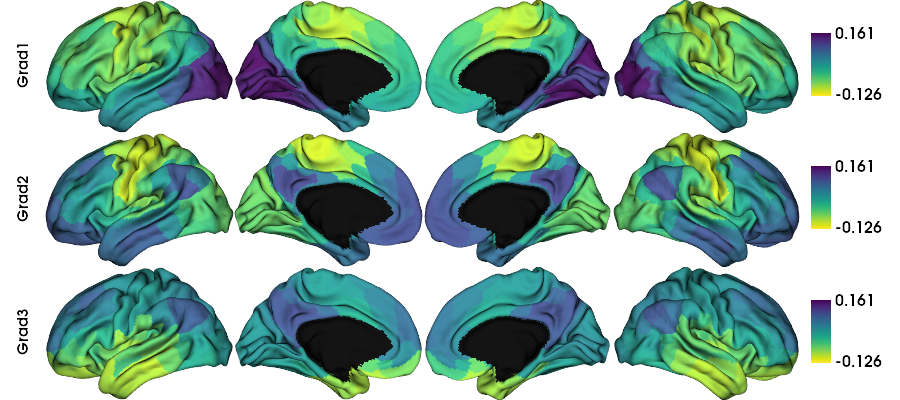

Saving plot for CTRL


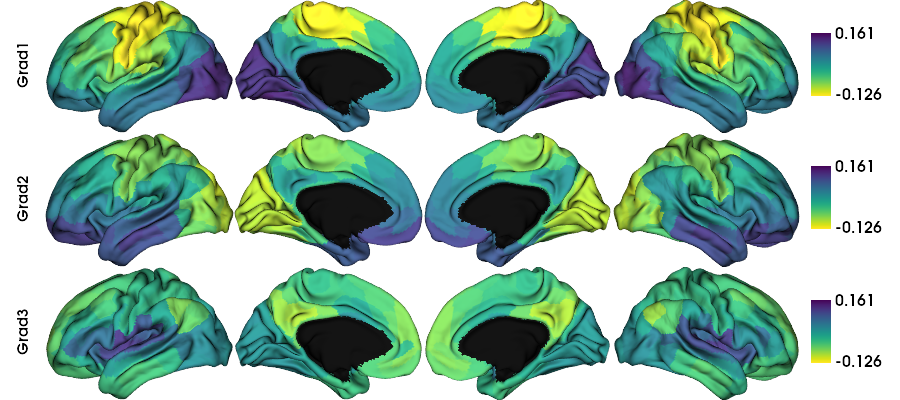

In [24]:
from IPython.display import Image, display

for group_name, grad_group in gradients_mapped.items():
    print(f"Saving plot for {group_name}")
    filename = f"{group_name}_gradient.png"
    plot_hemispheres(
        surf_lh, surf_rh,
        array_name=grad_group,
        size=(900, 400),
        cmap='viridis_r',
        color_bar=True,
        label_text=['Grad1', 'Grad2', 'Grad3'],
        zoom=1.8,
        color_range=color_range,
        interactive=False,
        screenshot=True,
        filename=filename
    )
    display(Image(filename))

# **Eccentrcity**

Saving eccentricity plot for SCHZ


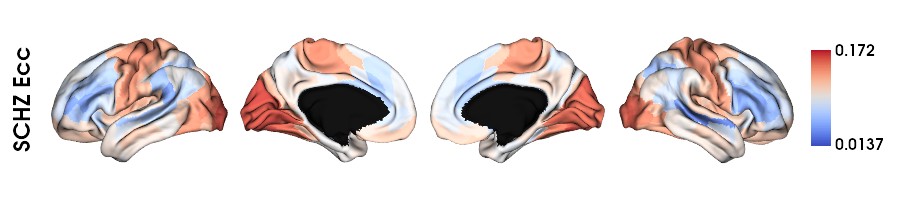

Saving eccentricity plot for SCHZaff


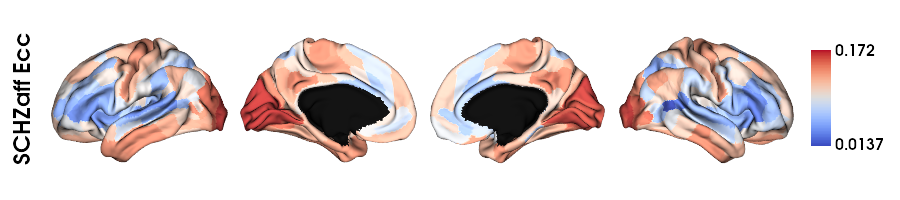

Saving eccentricity plot for BP


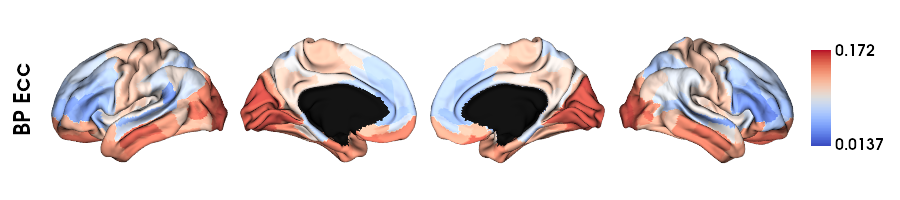

Saving eccentricity plot for REL_SCHZ


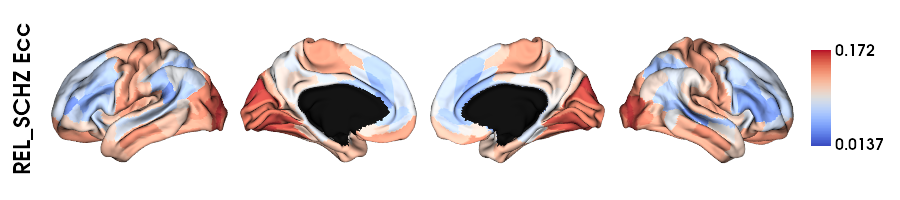

Saving eccentricity plot for REL_SCHZaff


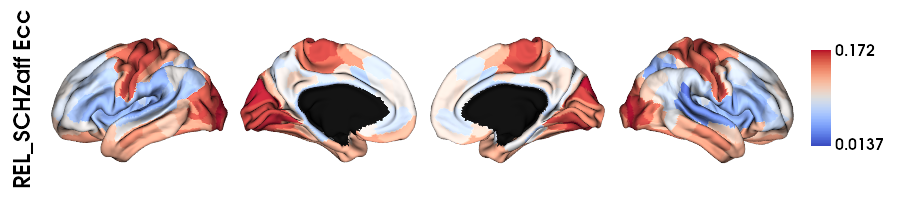

Saving eccentricity plot for REL_BP


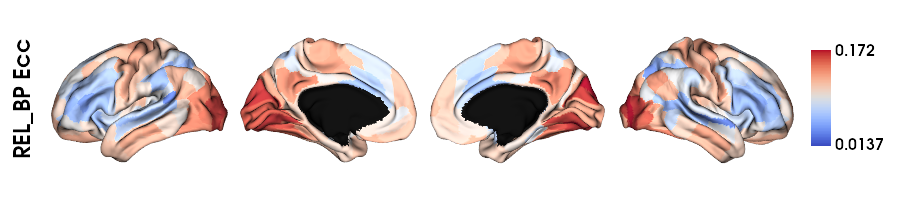

Saving eccentricity plot for CTRL


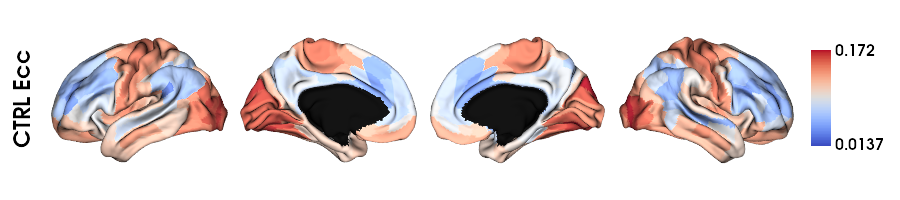

In [26]:
def eccentricity(g1, g2, g3):
    return np.sqrt(g1**2 + g2**2 + g3**2)

eccentricity_mapped = {}

for group_name, gm in gradients_dict.items():
    ecc = eccentricity(gm.gradients_[:, 0], gm.gradients_[:, 1], gm.gradients_[:, 2])
    ecc_mapped = map_to_labels(ecc, labeling, mask=mask, fill=np.nan)
    eccentricity_mapped[group_name] = ecc_mapped

vmin = np.nanmin(list(eccentricity_mapped.values()))
vmax = np.nanmax(list(eccentricity_mapped.values()))
ecc_color_range = (vmin, vmax)

from IPython.display import Image, display

from IPython.display import Image, display

for group_name, ecc_array in eccentricity_mapped.items():
    print(f"Saving eccentricity plot for {group_name}")
    filename = f"{group_name}_eccentricity.png"
    plot_hemispheres(
        surf_lh, surf_rh,
        array_name=ecc_array,
        size=(900, 200),
        cmap='coolwarm',
        color_bar=True,
        label_text=[f"{group_name} Ecc"],
        zoom=1.2,
        color_range=ecc_color_range,
        interactive=False,
        screenshot=True,
        filename=filename
    )
    display(Image(filename))

# **Individual aligned and unaligned gradients**

In [29]:
# Reference gradients from CTRL group
gm_ctrl = gradients_dict['CTRL']

# Prepare dictionaries to hold results for all subjects across groups
eccen_parcel_aligned_all = {}
eccen_net_aligned_all = {}

# List of all unique diagnosis codes you want to process (exclude CTRL if you want)
diagnosis_codes = demo['diagnosis'].unique()

# Optionally, skip CTRL group here if you only want to process patient groups
# diagnosis_codes = diagnosis_codes[diagnosis_codes != 7]

for diag_code in diagnosis_codes:
    # Filter demo for this group
    demo_group = demo[demo['diagnosis'] == diag_code].reset_index(drop=True)
    if demo_group.empty:
        print(f"No subjects found for diagnosis code {diag_code}, skipping.")
        continue
    
    # Get FC matrices for this group
    fc_group = np.array([fc.get(pid) for pid in demo_group['participant_id']])
    
    for i, subj_id in enumerate(demo_group['participant_id']):
        fc_mat = fc_group[i][:360, :360]
        
        model = GradientMaps(approach='pca', kernel='normalized_angle', 
                             alignment='procrustes', n_components=3, random_state=0)
        
        model.fit(fc_mat, sparsity=0.9, reference=gm_ctrl.gradients_)
        
        ecc = eccentricity(model.aligned_[:, 0], model.aligned_[:, 1], model.aligned_[:, 2])
        ecc_360 = ecc[:360]
        
        eccen_parcel_aligned_all[subj_id] = ecc_360
        network_360 = network[:360]
        
        net_avg = []
        for net_id in range(1, 9):
            net_mask = (network_360 == net_id)
            if np.sum(net_mask) == 0:
                net_avg.append(np.nan)
            else:
                net_avg.append(np.nanmean(ecc_360[net_mask]))
        eccen_net_aligned_all[subj_id] = net_avg

print(f"✅ Total subjects processed: {len(eccen_net_aligned_all)}")


✅ Total subjects processed: 317


In [30]:
import pandas as pd

# === Parcel-level eccentricity DataFrame ===
df_parcel = pd.DataFrame.from_dict(eccen_parcel_aligned_all, orient='index')
df_parcel.columns = ['node_' + str(i+1) for i in range(df_parcel.shape[1])]
df_parcel = df_parcel.rename_axis('participant_id').reset_index()

# Merge with full demographics table
df_parcel = pd.merge(demo, df_parcel, on='participant_id', how='inner')

# Convert diagnosis and gender to categorical
df_parcel['diagnosis'] = df_parcel['diagnosis'].astype('category')
df_parcel['diagnosis2'] = df_parcel['diagnosis2'].astype('category')
df_parcel['gender'] = df_parcel['gender'].astype('category')

# Now df_parcel looks like your example tmp_df
print(df_parcel.head())


# === Network-level eccentricity DataFrame ===
df_net = pd.DataFrame.from_dict(eccen_net_aligned_all, orient='index')
df_net.columns = ['net_' + str(i+1) for i in range(df_net.shape[1])]
df_net = df_net.rename_axis('participant_id').reset_index()

# Merge with full demographics table
df_net = pd.merge(demo, df_net, on='participant_id', how='inner')

# Convert diagnosis and gender to categorical
df_net['diagnosis'] = df_net['diagnosis'].astype('category')
df_net['diagnosis2'] = df_net['diagnosis2'].astype('category')
df_net['gender'] = df_net['gender'].astype('category')

# Now df_net looks like your example net_df
print(df_net.head())


  participant_id        subjectkey  interview_age sex diagnosis  group_code  \
0          sub01  NDAR_INV056VJPL6           45.6   F         1           1   
1          sub02  NDAR_INV05AFGN2Z           72.0   F         7           7   
2          sub03  NDAR_INV0647UAN8           28.8   F         6           6   
3          sub04  NDAR_INV09ZHCKN4           60.0   F         4           4   
4          sub05  NDAR_INV0HGGUV9D           31.2   M         1           1   

   group_simple diagnosis2 gender    node_1  ...  node_351  node_352  \
0             1          1      2  0.832515  ...  0.507944  1.641077   
1             4          7      2  1.593653  ...  1.091948  0.699010   
2             4          6      2  1.336164  ...  1.066485  1.100964   
3             4          4      2  1.152414  ...  0.778861  1.218936   
4             1          1      1  1.258310  ...  1.416914  1.072687   

   node_353  node_354  node_355  node_356  node_357  node_358  node_359  \
0  0.805313  0.85

## **Stats CTR vs SCZ p < 0.01**

In [32]:
import nibabel as nib
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from IPython.display import Image, display

# Load atlas (not needed for plotting here, but keep for context)
atlas = nib.load('./Glasser360_Tian_Subcortex_S4_3T.nii').get_fdata()[0]

In [ ]:
# Filter dataset for SCHZ (1) and CTRL (7) only
df_sub = df_parcel[df_parcel['diagnosis2'].isin([1, 7])].copy()

# Convert diagnosis2 to categorical and reorder so CTRL (7) is baseline/reference
df_sub['diagnosis2'] = df_sub['diagnosis2'].astype('category')
df_sub['diagnosis2'] = df_sub['diagnosis2'].cat.set_categories([7, 1], ordered=True)

# Make gender categorical
df_sub['gender'] = df_sub['gender'].astype('category')

n_nodes = 360
models = [None] * n_nodes

for i in range(n_nodes):
    node_col = f'node_{i+1}'
    formula = f'{node_col} ~ C(diagnosis2) + interview_age + C(gender)'
    models[i] = smf.ols(formula, data=df_sub).fit()

pvals_diag = np.array([models[i].pvalues.get('C(diagnosis2)[T.1]', np.nan) for i in range(n_nodes)])
pvals_age = np.array([models[i].pvalues.get('interview_age', np.nan) for i in range(n_nodes)])
pvals_gender = np.array([models[i].pvalues.get('C(gender)[T.2]', np.nan) for i in range(n_nodes)])

tvals_diag = np.array([models[i].tvalues.get('C(diagnosis2)[T.1]', 0) for i in range(n_nodes)])
tvals_age = np.array([models[i].tvalues.get('interview_age', 0) for i in range(n_nodes)])
tvals_gender = np.array([models[i].tvalues.get('C(gender)[T.2]', 0) for i in range(n_nodes)])

# FDR correction for age and gender
_, pvals_age_fdr = fdrcorrection(pvals_age, alpha=0.05)
_, pvals_gender_fdr = fdrcorrection(pvals_gender, alpha=0.05)

# Threshold t-values by significance
tvals_diag[pvals_diag > 0.01] = 0
tvals_age[pvals_age_fdr > 0.05] = 0
tvals_gender[pvals_gender_fdr > 0.05] = 0

# Make a dictionary for easy looping and plotting
tvals_dict = {
    'Diagnosis2': tvals_diag,
    'Age': tvals_age,
    'Gender': tvals_gender
}

ecc_color_range = (-3, 3)  # example color range for t-values

Plotting Diagnosis2 t-values


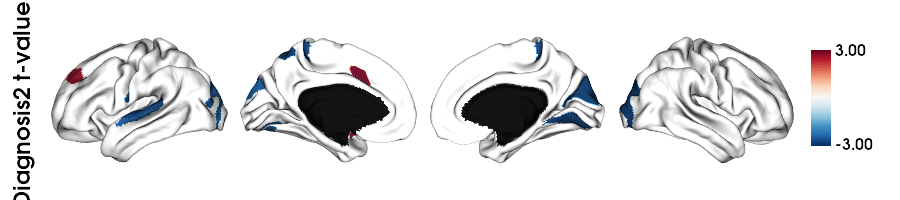

Plotting Age t-values


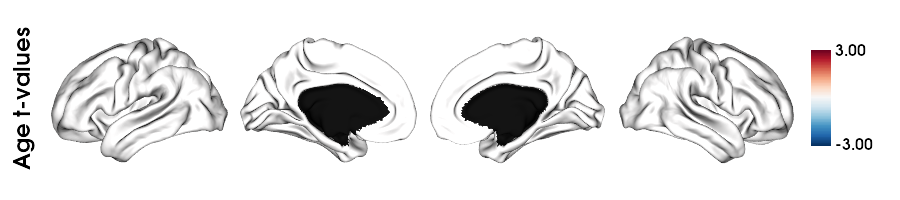

Plotting Gender t-values


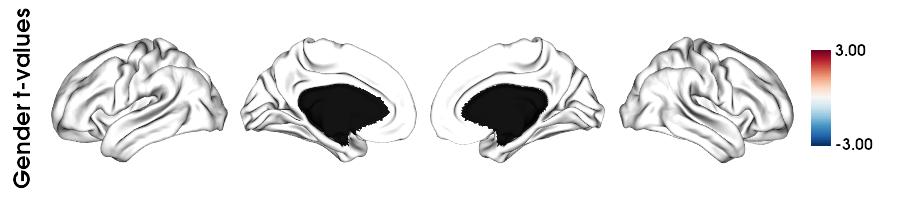

In [42]:
import numpy as np
from brainspace.utils.parcellation import map_to_labels
from brainspace.plotting import plot_hemispheres

mask = labeling != 0
mapped_tvals = dict()

for name, tvals in tvals_dict.items():
    # map parcel-wise t-values to vertices
    mapped_array = map_to_labels(tvals, labeling, mask=mask, fill=np.nan)
    mapped_tvals[name] = mapped_array

for name, vertex_data in mapped_tvals.items():
    print(f"Plotting {name} t-values")
    plot_hemispheres(
        surf_lh, surf_rh,
        array_name=vertex_data,  # ✅ full-length 64984 array
        size=(900, 200),
        cmap='RdBu_r',
        color_bar=True,
        label_text=[f"{name} t-values"],
        zoom=1.2,
        color_range=(-3, 3),
        interactive=False,
        screenshot=True,
        filename=f"{name}_tvals_plot.png"
    )
    display(Image(f"{name}_tvals_plot.png"))


In [60]:
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import pandas as pd
import numpy as np

# Make sure categorical variables are set up properly
df_net['diagnosis2'] = df_net['diagnosis2'].astype('category')
df_net['diagnosis2'] = df_net['diagnosis2'].cat.set_categories([7, 1], ordered=True)  # 7 = CTRL, 1 = SCHZ
df_net['gender'] = df_net['gender'].astype('category')

# Fit models for net_1 to net_7
models = []
for i in range(7):  # net_1 to net_7
    net_col = f'net_{i+1}'
    formula = f'{net_col} ~ C(diagnosis2) + interview_age + C(gender)'
    model = smf.ols(formula, data=df_net).fit()
    models.append(model)

# Extract t-values and p-values for diagnosis effect
tvals = np.array([m.tvalues.get('C(diagnosis2)[T.1]', np.nan) for m in models])
pvals = np.array([m.pvalues.get('C(diagnosis2)[T.1]', np.nan) for m in models])
_, pvals_fdr = fdrcorrection(pvals, alpha=0.05)

# Create summary DataFrame
sts = pd.DataFrame({
    'Network': net_name[1:8],
    't-value (diagnosis2)': tvals,
    'p-value': pvals,
    'FDR-corrected p': pvals_fdr
})

# Optional: Display nicely
sts.style.set_caption("SCHZ vs CTRL: Network-Level T-values")
